In [113]:
!conda install \
   --yes \
   -c conda-forge \
   'lightgbm>=3.3.3'

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



## Package Plan ##

  environment location: /Users/yoav/anaconda3

  added / updated specs:
    - lightgbm[version='>=3.3.3']


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.11.17 |       hf0a4a13_0         151 KB  conda-forge
    certifi-2023.11.17         |     pyhd8ed1ab_0         155 KB  conda-forge
    lightgbm-4.1.0             |   py39h313beb8_0         1.2 MB
    scipy-1.11.3               |   py39h20cbe94_0        19.5 MB
    ------------------------------------------------------------
                      

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize, scale
from scipy import stats
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score
from xgboost import XGBClassifier
import pylab
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from lightgbm import LGBMClassifier

In [142]:
warnings.filterwarnings("ignore")

In [17]:
intakes = pd.read_csv('Austin_Animal_Center_Intakes.csv')
outcomes = pd.read_csv('Austin_Animal_Center_Outcomes.csv')
df = outcomes.merge(intakes, how='left', on='Animal ID')
df.head()

,Animal ID,Name_x,DateTime_x,MonthYear_x,Date of Birth,Outcome Type,Outcome Subtype,Animal Type_x,Sex upon Outcome,Age upon Outcome,...,DateTime_y,MonthYear_y,Found Location,Intake Type,Intake Condition,Animal Type_y,Sex upon Intake,Age upon Intake,Breed_y,Color_y
0,A794011,Chunk,05/08/2019 06:20:00 PM,May 2019,05/02/2017,Rto-Adopt,NaN,Cat,Neutered Male,2 years,...,05/02/2019 04:51:00 PM,May 2019,Austin (TX),Owner Surrender,Normal,Cat,Neutered Male,2 years,Domestic Shorthair Mix,Brown Tabby/White
1,A776359,Gizmo,07/18/2018 04:02:00 PM,Jul 2018,07/12/2017,Adoption,NaN,Dog,Neutered Male,1 year,...,07/12/2018 12:46:00 PM,July 2018,7201 Levander Loop in Austin (TX),Stray,Normal,Dog,Intact Male,1 year,Chihuahua Shorthair Mix,White/Brown
2,A821648,NaN,08/16/2020 11:38:00 AM,Aug 2020,08/16/2019,Euthanasia,NaN,Other,Unknown,1 year,...,08/16/2020 10:10:00 AM,August 2020,Armadillo Rd And Clubway Ln in Austin (TX),Wildlife,Sick,Other,Unknown,1 year,Raccoon,Gray
3,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,...,02/08/2016 11:05:00 AM,February 2016,Dove Dr And E Stassney in Austin (TX),Stray,Normal,Dog,Intact Male,4 months,Anatol Shepherd/Labrador Retriever,Buff
4,A720371,Moose,02/13/2016 05:59:00 PM,Feb 2016,10/08/2015,Adoption,NaN,Dog,Neutered Male,4 months,...,02/15/2016 10:37:00 AM,February 2016,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,4 months,Anatol Shepherd/Labrador Retriever,Buff


In [125]:
outcomes[outcomes['Animal ID'] == 'Burrito']

,Animal ID,Name,DateTime,MonthYear,Date of Birth,Outcome Type,Outcome Subtype,Animal Type,Sex upon Outcome,Age upon Outcome,Breed,Color


In [6]:
# df.columns

Index(['Animal ID', 'Name_x', 'DateTime_x', 'MonthYear_x', 'Date of Birth',
       'Outcome Type', 'Outcome Subtype', 'Animal Type_x', 'Sex upon Outcome',
       'Age upon Outcome', 'Breed_x', 'Color_x', 'Name_y', 'DateTime_y',
       'MonthYear_y', 'Found Location', 'Intake Type', 'Intake Condition',
       'Animal Type_y', 'Sex upon Intake', 'Age upon Intake', 'Breed_y',
       'Color_y'],
      dtype='object')

In [18]:
df['y'] = ((df['Outcome Type'] == 'Adoption') | (df['Outcome Type'] == 'Rto-Adopt'))
df.y = df.y.astype(int)
df[['Outcome Type','y']]

,Outcome Type,y
0,Rto-Adopt,1
1,Adoption,1
2,Euthanasia,0
3,Adoption,1
4,Adoption,1
...,...,...
202369,Adoption,1
202370,Adoption,1
202371,Adoption,1
202372,Adoption,1


In [19]:
df.drop(['Name_x', 'Name_y','Outcome Subtype'], axis=1, inplace=True)
df.dropna(inplace=True)

In [20]:
# df.info()

In [21]:
def age_in_months(age_str):
  split = age_str.split(' ')
  label = split[1]
  age = int(split[0])
  if label == 'year' or label == 'years':
    age *= 365
  elif label == 'week' or label == 'weeks':
    age *= 7
  elif label == 'month' or label == 'months':
    age *= 30
  return age

In [22]:
df['Age upon Intake'] = df['Age upon Intake'].apply(lambda x: age_in_months(x))
df['Age upon Outcome'] = df['Age upon Outcome'].apply(lambda x: age_in_months(x))

In [23]:
df.DateTime_x = pd.to_datetime(df.DateTime_x)
df.DateTime_y = pd.to_datetime(df.DateTime_y)
df['Time_in_shelter'] = df.DateTime_x - df.DateTime_y

/var/folders/2c/9w735kj12jbd75x2pmhw03d00000gn/T/ipykernel_17498/1141793705.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.DateTime_x = pd.to_datetime(df.DateTime_x)
/var/folders/2c/9w735kj12jbd75x2pmhw03d00000gn/T/ipykernel_17498/1141793705.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.DateTime_y = pd.to_datetime(df.DateTime_y)


In [24]:
df.Time_in_shelter = df.Time_in_shelter.astype(int) / 60000000000

In [25]:
def get_fixed_status(input_str):
  status = input_str.split(' ')[0]
  return 1 if status == 'Neutered' or status == 'Spayed' else 0

In [26]:
def get_gender(input_str):
  split = input_str.split(' ')
  if len(split) < 2:
    return 'unknown'
  else:
    return split[1]

In [27]:
df['Is_fixed'] = df['Sex upon Outcome'].apply(lambda x: get_fixed_status(x))
df['Gender'] = df['Sex upon Outcome'].apply(lambda x: get_gender(x))

In [43]:
df['Primary_breed'] = df['Breed_x'].apply(lambda x: x.split('/')[0].replace(' Mix', ''))
df.Primary_breed.unique()

array(['Domestic Shorthair', 'Chihuahua Shorthair', 'Raccoon',
       'Anatol Shepherd', 'American Foxhound', 'Border Collie',
       'Pit Bull', 'Domestic Medium Hair', 'Opossum', 'Weimaraner', 'Bat',
       'Yorkshire Terrier', 'Jack Russell Terrier', 'Great Pyrenees',
       'Australian Cattle Dog', 'Beagle', 'Labrador Retriever',
       'German Shepherd', 'Staffordshire', 'Dogo Argentino',
       'Black Mouth Cur', 'Collie Rough', 'Polish', 'Rat Terrier',
       'Doberman Pinsch', 'American Staffordshire Terrier',
       'Miniature Poodle', 'Dachshund', 'Standard Schnauzer', 'Pug',
       'American Bulldog', 'American Pit Bull Terrier', 'Siberian Husky',
       'Australian Kelpie', 'Miniature Schnauzer', 'Miniature Pinscher',
       'Boxer', 'Catahoula', 'Standard Poodle', 'Siamese',
       'Queensland Heeler', 'Border Terrier', 'Flat Coat Retriever',
       'Mastiff', 'Cairn Terrier', 'American Eskimo', 'Boston Terrier',
       'Vizsla', 'Guinea Pig', 'Shiba Inu', 'Rabbit Sh', 'Ro

In [32]:
df['Primary_color'] = df.Color_x.apply(lambda x: x.split('/')[0].split(' ')[0])
df['Secondary_color'] = df.Color_x.apply(lambda x: 'N/A' if '/' not in x else x.split('/')[1].split(' ')[0])

In [41]:
df['Normal_condition'] = df['Intake Condition'].apply(lambda x: 1 if x == 'Normal' else 0)

0         1
1         1
2         0
3         1
4         1
         ..
202369    0
202370    1
202371    1
202372    1
202373    1
Name: Normal_condition, Length: 201511, dtype: int64

In [84]:
df = df[(df['Animal Type_x'] == 'Dog') | (df['Animal Type_x'] == 'Cat')]

In [85]:
X = df[['Primary_color', 'Secondary_color', 'Age upon Outcome', 'Age upon Intake', 'Is_fixed', 'Gender', 'Primary_breed', 'Time_in_shelter', 'Animal Type_x', 'Normal_condition']]
y = df['y']

<Axes: >

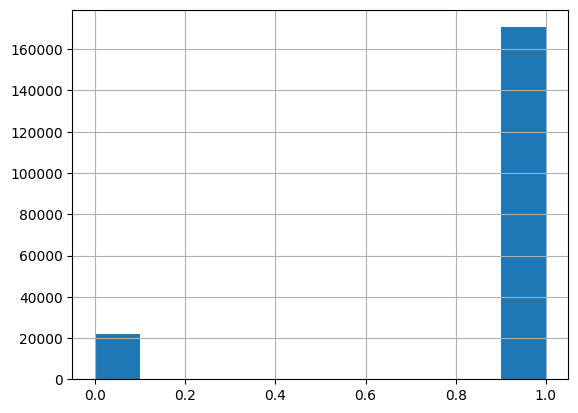

In [94]:
df['Normal_condition'].hist()

In [87]:
X_ohe = pd.get_dummies(X)
X_ohe.columns

Index(['Age upon Outcome', 'Age upon Intake', 'Is_fixed', 'Time_in_shelter',
       'Normal_condition', 'Primary_color_Agouti', 'Primary_color_Apricot',
       'Primary_color_Black', 'Primary_color_Blue', 'Primary_color_Brown',
       ...
       'Primary_breed_Welsh Terrier', 'Primary_breed_West Highland',
       'Primary_breed_Whippet', 'Primary_breed_Wire Hair Fox Terrier',
       'Primary_breed_Wirehaired Pointing Griffon',
       'Primary_breed_Wirehaired Vizsla', 'Primary_breed_Wolf Hybrid',
       'Primary_breed_Yorkshire Terrier', 'Animal Type_x_Cat',
       'Animal Type_x_Dog'],
      dtype='object', length=318)

In [88]:
X_ohe.to_csv('X.csv')
y.to_csv('y.csv')

In [89]:
X_ohe = pd.read_csv('X.csv', index_col=0)
y = pd.read_csv('y.csv', index_col=0)

In [90]:
all_data = pd.concat([X_ohe, y], axis=1).drop_duplicates()
all_data.shape

(189044, 319)

In [97]:
test = all_data.sample(frac=.1, axis=0)
train = pd.concat([all_data,test]).drop_duplicates(keep=False)

y_train = train['y']
X_train = train.drop(['y'], axis=1)

y_test = test['y']
X_test = test.drop(['y'], axis=1)

In [58]:
auc_scorer = make_scorer(roc_auc_score)
def auc_cv(model):
    auc = cross_val_score(model, X_train, y_train, scoring=auc_scorer, cv = 5)
    return(auc)

/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: 

/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: 

/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/yoav/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: 

Text(0, 0.5, 'auc')

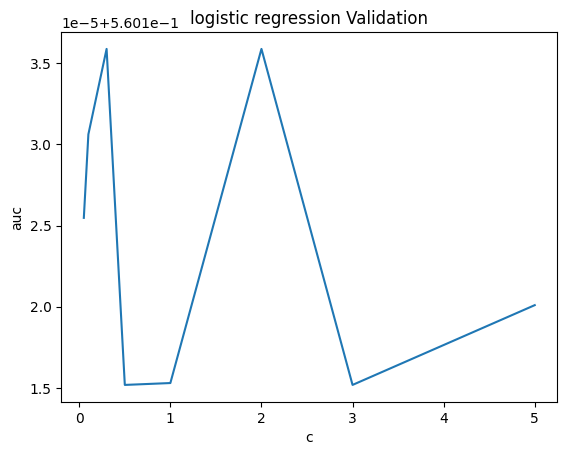

In [124]:
cs = [0.05, 0.1, 0.3, .5, 1, 2, 3, 5]
cv_lr_l1 = [auc_cv(LogisticRegression(solver='saga', penalty='l1', C = c)).mean() 
            for c in cs]
cv_ridge = pd.Series(cv_lr_l1, index = cs)
cv_ridge.plot(title = "logistic regression Validation")
plt.xlabel("c")
plt.ylabel("auc")

In [23]:
# xgb = XGBClassifier()
# xgb.fit(X_ohe, y)
# importances = xgb.feature_importances_
# importances = pd.Series(importances)
# importances.sort_values(inplace=True, ascending=False)

In [24]:
# importances

In [92]:
params = { 'max_depth': [3, 5, 8],
           'colsample_bytree': [0.3, .7, 1],
             'reg_alpha': [1, 5, 10],
            'reg_lambda': [.5, 1, 3],
         'learning_rate': [.05, .1, .3]}
xgbc = XGBClassifier(random_state=1)
clf = GridSearchCV(estimator=xgbc,
                   param_grid=params,
                   verbose=2, cv=5, n_jobs=-1, scoring=auc_scorer)
clf.fit(X_train, y_train, verbose=False)
print("Best parameters:", clf.best_params_)
print("Best score: ", clf.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 8, 'reg_alpha': 5, 'reg_lambda': 3}
Best score:  0.8102812522133365
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=1, reg_lambda=1; total time=  11.2s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=1, reg_lambda=3; total time=  10.9s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=0.5; total time=  10.6s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=3; total time=   9.7s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=10, reg_lambda=1; total time=   9.6s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=10, reg_lambda=3; total time=  10.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=1, reg_lambda=1; total time=  10.0s
[CV] END colsamp

[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=1, reg_lambda=0.5; total time=  11.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=1, reg_lambda=3; total time=  10.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=0.5; total time=  11.7s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=10, reg_lambda=0.5; total time=   9.7s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=10, reg_lambda=1; total time=   9.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=10, reg_lambda=3; total time=   9.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=1, reg_lambda=1; total time=   9.9s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=1, reg_lambda=3; total time=   9.9s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=5, reg_lambda=1; total time=  10.5s
[

[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=1, reg_lambda=0.5; total time=  11.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=1, reg_lambda=3; total time=  11.5s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=1; total time=  10.5s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=3; total time=   9.6s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=10, reg_lambda=1; total time=   9.6s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=1, reg_lambda=0.5; total time=  11.8s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=1, reg_lambda=3; total time=  10.4s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=5, reg_lambda=0.5; total time=  10.1s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=5, reg_lambda=3; total time=  10.1s
[CV

[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=1, reg_lambda=1; total time=  11.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=1, reg_lambda=3; total time=  11.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=1; total time=  10.6s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=3; total time=   9.8s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=10, reg_lambda=1; total time=   9.6s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=1, reg_lambda=0.5; total time=  11.4s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=1, reg_lambda=1; total time=   9.0s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=5, reg_lambda=0.5; total time=  10.0s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=5, reg_lambda=1; total time=  10.2s
[CV] 

[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=1, reg_lambda=0.5; total time=  11.5s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=0.5; total time=  10.1s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=0.5; total time=  10.1s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=3; total time=   9.8s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=10, reg_lambda=0.5; total time=   9.9s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=10, reg_lambda=3; total time=   9.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=1, reg_lambda=0.5; total time=  10.0s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=1, reg_lambda=3; total time=   9.9s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=5, reg_lambda=1; total time=  10.4

[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=1, reg_lambda=0.5; total time=  11.1s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=1, reg_lambda=1; total time=  10.5s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=0.5; total time=  10.1s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=5, reg_lambda=1; total time=   9.8s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=10, reg_lambda=0.5; total time=   9.4s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=3, reg_alpha=10, reg_lambda=3; total time=   8.9s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=1, reg_lambda=0.5; total time=   9.9s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=1, reg_lambda=3; total time=   9.5s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=5, reg_alpha=5, reg_lambda=0.5; total time=  10.1

In [119]:
params = { 'max_depth': [8, 12],
            'n_estimators': [100, 200],
           'colsample_bytree': [0.3, .7],
             'reg_alpha': [3, 5, 7],
            'reg_lambda': [2, 3, 5],
         'learning_rate': [.5, .3]}
xgbc = XGBClassifier(random_state=1)
clf = GridSearchCV(estimator=xgbc,
                   param_grid=params,
                   verbose=2, cv=5, n_jobs=-1, scoring=auc_scorer)
clf.fit(X_train, y_train, verbose=False)
print("Best parameters:", clf.best_params_)
print("Best score: ", clf.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 8, 'n_estimators': 100, 'reg_alpha': 3, 'reg_lambda': 2}
Best score:  0.809925897029478


In [120]:
xgb = XGBClassifier(colsample_bytree=0.7, learning_rate=0.3, max_depth=8, reg_alpha=3, reg_lambda=2)
xgb.fit(X_train, y_train)
pd.Series(xgb.feature_importances_).sort_values(ascending=False)

2      0.602708
0      0.025428
3      0.017976
257    0.016036
63     0.013131
         ...   
209    0.000000
211    0.000000
96     0.000000
213    0.000000
162    0.000000
Length: 318, dtype: float32

In [121]:
yhat = xgb.predict_proba(X_test)
roc_auc_score(y_test, yhat[:, 1])

0.9010473694587424

[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=2; total time=  12.1s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=3; total time=  12.3s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=2; total time=  13.0s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=5; total time=  11.2s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=3; total time=  10.7s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=2; total time=  15.8s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=3; total time=  15.7s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=5, reg_lambda=2; tot

[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=2; total time=  12.1s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=3; total time=  12.4s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=3; total time=  11.3s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=5; total time=  11.7s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=3; total time=  11.1s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=5; total time=  11.1s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=3; total time=  13.8s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=5; tot

[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=3; total time=  12.2s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=5; total time=  12.1s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=2; total time=  13.8s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=2; total time=  11.1s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=3; total time=  10.7s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=2; total time=  15.1s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=3; total time=  15.7s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=5, reg_lambda=2; tot

[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=3; total time=  12.3s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=5; total time=  11.7s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=2; total time=  11.0s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=3; total time=   9.8s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=2; total time=  10.5s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=5; total time=   9.9s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=2; total time=  15.1s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=5; tot

[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=2; total time=  12.6s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=2; total time=  12.4s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=3; total time=  10.6s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=5; total time=  11.4s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=2; total time=  11.3s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=5; total time=  11.0s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=3; total time=  15.0s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=5; tot

[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=3; total time=  12.3s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=5; total time=  12.2s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=3; total time=  12.9s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=5; total time=  11.6s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=3; total time=  10.8s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=2; total time=  15.7s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=5; total time=  15.9s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=5, reg_lambda=2; tot

[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=2; total time=  12.5s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=3, reg_lambda=5; total time=  11.7s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=5, reg_lambda=3; total time=  14.2s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=2; total time=   9.1s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=3; total time=  11.1s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=100, reg_alpha=7, reg_lambda=5; total time=  11.4s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=3, reg_lambda=3; total time=  15.2s
[CV] END colsample_bytree=0.3, learning_rate=0.5, max_depth=8, n_estimators=200, reg_alpha=5, reg_lambda=2; tot

In [104]:
X_train.head()

,Age upon Outcome,Age upon Intake,Is_fixed,Time_in_shelter,Normal_condition,Primary_color_Agouti,Primary_color_Apricot,Primary_color_Black,Primary_color_Blue,Primary_color_Brown,...,Primary_breed_Welsh Terrier,Primary_breed_West Highland,Primary_breed_Whippet,Primary_breed_Wire Hair Fox Terrier,Primary_breed_Wirehaired Pointing Griffon,Primary_breed_Wirehaired Vizsla,Primary_breed_Wolf Hybrid,Primary_breed_Yorkshire Terrier,Animal Type_x_Cat,Animal Type_x_Dog
0,730,730,1,8729.0,1,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
1,365,365,1,8836.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,120,120,1,7614.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,120,120,1,-2438.0,1,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
5,6,6,0,276.0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [144]:
#boosting_type='dart', feature_fraction=0.9, learning_rate=1, max_depth=6, num_iterations=300, objective='binary'
lgbm = LGBMClassifier(boosting_type='dart', objective='binary', num_threads=10)
params = {
         'num_iterations': [100, 300, 500],
         'learning_rate': [.1, .3, .5],
         'lambda_l1': [.5, 1, 3, 5],
         }
rfc = RandomForestClassifier(random_state=1)
clf = GridSearchCV(estimator=lgbm, 
                   param_grid=params, cv=5)

clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Best score: ", clf.best_score_)
# lgbm.fit(X_train, y_train)
# yhat_lgbm = lgbm.predict_proba(X_test)
# roc_auc_score(y_test, yhat_lgbm[:, 1])

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 214
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [War

[LightGBM] [Warning] lambda_l1 is set=0.5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003194 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 214
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 214
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 773
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 216
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 769
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 214
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 213
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003288 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 212
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Info] Number of positive: 69692, number of negative: 66420
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 763
[LightGBM] [Info] Number of data points in the train set: 136112, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ign

[LightGBM] [Warning] lambda_l1 is set=5, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Info] Number of positive: 87115, number of negative: 83025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004506 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 170140, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
Best parameters: {'lambda_l1': 3, 'learning_rate': 0.3, 'num_itera

In [145]:
lgbm = LGBMClassifier(boosting_type='dart', objective='binary', num_threads=10,lambda_l1=3,learning_rate=0.3, num_iterations=500)
lgbm.fit(X_train, y_train)
yhat_lgbm = lgbm.predict_proba(X_test)
roc_auc_score(y_test, yhat_lgbm[:, 1])

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Info] Number of positive: 87115, number of negative: 83025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 170140, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3


0.9016208210062866

In [137]:
params = {'n_estimators': [10, 50, 100, 500],
           'max_depth': [None, 10, 20, 30]}
rfc = RandomForestClassifier(random_state=1)
clf = GridSearchCV(estimator=rfc, 
                   param_grid=params,
                   verbose=1, cv=5)

clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Best score: ", clf.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters: {'max_depth': 30, 'n_estimators': 500}
Best score:  0.8041260138709297


In [139]:
rfc = RandomForestClassifier(max_depth=30, n_estimators=500)
rfc.fit(X_train, y_train)
yhat_rfc = rfc.predict_proba(X_test)
roc_auc_score(y_test, yhat_rfc[:, 1])

0.8975438069629619

In [146]:
estimators = [
    ('lgbm',LGBMClassifier(boosting_type='dart', objective='binary', num_threads=10,lambda_l1=3,learning_rate=0.3, num_iterations=500)),
    ('rf', RandomForestClassifier(max_depth=30, n_estimators=500))
]
stacker = StackingClassifier(
    estimators=estimators, final_estimator=xgb, passthrough=True
)
stacker.fit(X_train, y_train)
yhat_stack = stacker.predict_proba(X_test)
roc_auc_score(y_test, yhat_stack[:, 1])


[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Info] Number of positive: 87115, number of negative: 83025
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 170140, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512020 -> initscore=0.048087
[LightGBM] [Info] Start training from score 0.048087
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] Found whitespace in feature_names, replace wi

0.905122927529621